<a href="https://colab.research.google.com/github/abol-hasan/Food_101/blob/main/101_food_Zaman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training food 101 from TSDF tensorflow using mix_precision

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-72abb3e5-481c-1e41-702e-dc563fa0947d)


In [ ]:
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

**- There a problem with the latest version of Tensorflow for running this. As result it is downgraded to 2.4.1**

In [ ]:
!pip install tensorflow==2.4.1
#!pip install --upgrade tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 462 kB 39.5 MB/s 
     |████████████████████████████████| 2.9 MB 38.3 MB/s 
     |████████████████████████████████| 3.8 MB 45.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

**-defining some fuctions: 1- Tensorboard,**
**2-plotting loss and accuracy,**
**3- plotting feature extraction and fine-tuning for comparing the results of** **them.** 

In [ ]:
import datetime
def establish_tensorboard(dir_name, exper_name):
  log_dir = dir_name +'/' + exper_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'save_to:{log_dir}')
  return tensorboard_callback

In [ ]:
def plot_loss_acc_curve(history):
  '''
  Arg: history comes from model.fit()
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, acc, label='train_accuracy')
  plt.plot(epochs, val_acc, label= 'val_accuracy')
  plt.title('ACURRACY')
  plt.xlabel('EPOCHS')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, label ='train_loss')
  plt.plot(epochs, val_loss, label ='val_loss')
  plt.title('LOSS')
  plt.xlabel('EPOCHS')
  plt.legend()

In [ ]:
def compare_finetune_history(org_hist, new_hist, init_epoch=5):
  '''
  A function for comparing before and after fine_tuning
  Arg:
  org_hist : original history of model before fine tuning
  new_hist : history of model after fine tuning
  init_epochs: Number of epochs in original_history
  '''
  acc = org_hist.history['accuracy']
  val_acc = org_hist.history['val_accuracy']

  loss = org_hist.history['loss']
  val_loss = org_hist.history['val_loss']

  sum_both_hist_acc = acc + new_hist.history['accuracy']
  sum_both_hist_val_acc = val_acc + new_hist.history['val_accuracy']

  sum_both_hist_loss = loss + new_hist.history['loss']
  sum_both_hist_val_loss = val_loss + new_hist.history['val_loss']
  epochs = range(len(sum_both_hist_loss))

  plt.figure(figsize=(12,8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs, sum_both_hist_acc, label = 'Train_accuracy' )
  plt.plot(epochs, sum_both_hist_val_acc, label = 'vall_accuracy')
  plt.plot([init_epoch-1, init_epoch-1],
              plt.ylim(), label='Start Fine Tuning') 
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 1)
  plt.plot(epochs, sum_both_hist_loss, label = 'Train_loss' )
  plt.plot(epochs, sum_both_hist_val_loss, label = 'vall_loss')
  plt.plot([init_epoch-1, init_epoch-1],
              plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show() 

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

**-Using Tensorflow datasets(TFDS).**
**-From image classification, food101, with 101 food classes and 101000 images.**

In [ ]:
import tensorflow_datasets as tfds
(train_dataset, test_dataset), dataset_info = tfds.load(name = 'food101', split=['train', 'validation'], shuffle_files=False,
                                                        as_supervised= True, with_info= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteJ7EOU7/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteJ7EOU7/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


- **getting familiar with Dataset**

In [ ]:
name_of_classes = dataset_info.features['label'].names
name_of_classes


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
image_sample = train_dataset.take(6)
image_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
for image , label in image_sample:
  print(f'Image size:{image.shape},\n kind of label(int or OneHotencoded):{label}')

Image size:(512, 512, 3),
 kind of label(int or OneHotencoded):56
Image size:(384, 512, 3),
 kind of label(int or OneHotencoded):76
Image size:(512, 512, 3),
 kind of label(int or OneHotencoded):21
Image size:(512, 512, 3),
 kind of label(int or OneHotencoded):64
Image size:(512, 512, 3),
 kind of label(int or OneHotencoded):10
Image size:(512, 512, 3),
 kind of label(int or OneHotencoded):70



**1.Defining a function for preparing our data for training.**  

**2.They have to be float32 for using in Tensorflow.**

**3.They have to have the same shape.** 








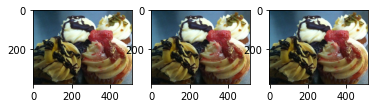

In [ ]:
import random
sample = test_dataset.take(1)
for image, label in sample:
  for i in range(3):
    ax = plt.subplot(1,3, 1+i)
    img = random.choice(image)
    plt.imshow(image)

In [ ]:
def preprocess_image(image, label, Image_shape=224 ,scale=False):
  '''
  Transforming datatype and the shape of images
  return: a tuple of   image with float32 and label
  '''
  image = tf.image.resize(image, [Image_shape, Image_shape])
  image = tf.cast(image, dtype=tf.float32)
  if scale== True:
    image = image/255
  return image, label

**1.** **Mapping the preprocess_image function to training data and test data.**

   **--using num_parallel_calls for improving speed.**  

**2.** **After that turning data into batches in the sake of memory problems.**   

**3. prefetch means here , while the model is finding pattern on one batch of the** **training data, get another batch ready to go.**





 

In [ ]:
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=2000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


**---Plotting some images**





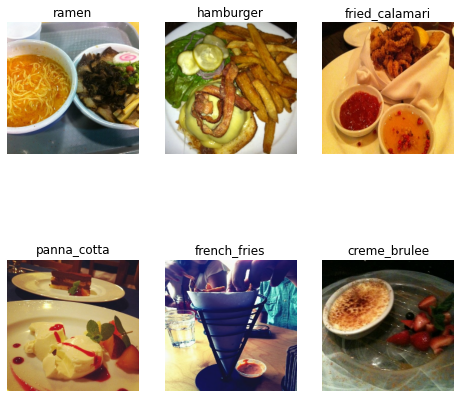

In [ ]:
plt.figure(figsize=(8,8))

for image, label in  train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, 1+i)
    
    plt.imshow(image[i].numpy()/255.)
    plt.title(name_of_classes[label[i]])
    plt.axis('off')


In [ ]:
for image, label in train_dataset.take(1):
  print(f'kind of label:{label}')
  print(len(label))



kind of label:[75 12 13 67 97 58 68 26 30 53 65 31 20 14 30 84 83 27 64  5 89 26 70  4
  6 47  1  4 97 14 37 27]
32


In [ ]:
import os
#checkpoint_filepath = weights.{epoch:02d}-{val_loss:.2f}.hdf5
#checkpoint_filepath =  os.path.join(working_dir, 'ckpt', file_name)
checkpoint_filepath = 'model_checkpoint/cp.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose = 0,
    save_best_only=True)

----**Utilization of float32 and float16, we can fit more in on our GPU so that** **it is able to compute on more tensors od float16 type at the same time** **rather than being clogged up with float32**. 

-Turning on mixed precision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


---**Creating a model for feature extraction by using a pretrained EfficientNetB0**.

freezing all layers from pretrained model and giving our data as a input and  creating output in which here all images have to be flaot32.

In [ ]:

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False)
base_model.trainable = False

inputs = layers.Input(input_shape , name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(101)(x)
outputs = layers.Activation('softmax', dtype = tf.float32, name = 'output_float32')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
output_float32 True float32 <Policy "float32">


In [ ]:
for i,layer in enumerate(model.layers[1].layers[:20]):
  print(i,layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_1 False float32 <Policy "float32">
1 rescaling False float32 <Policy "mixed_float16">
2 normalization False float32 <Policy "float32">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Policy "mixed

In [ ]:
mix_precision_hsitory = model.fit(train_dataset, epochs =3, steps_per_epoch=len(train_dataset), validation_data=test_dataset,
                                  validation_steps=int(0.15 * len(test_dataset)),
                                  callbacks=[establish_tensorboard('mix_percision', 'feature_extraction_full_data'),
                                             model_checkpoint_callback])
                                  
                                  

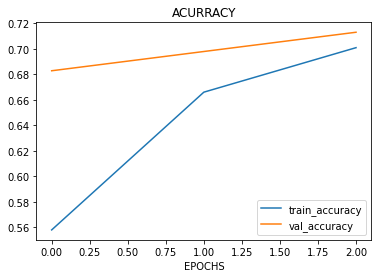

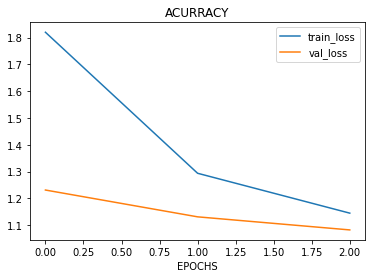

In [ ]:
plot_loss_acc_curve(mix_precision_hsitory)

In [ ]:
feature_extract_model_eval = model.evaluate(test_dataset)

790/790 [==============================] - 86s 109ms/step - loss: 1.0888 - accuracy: 0.7089


In [ ]:
# Save model
dir_save_model = 'feature_extract_EfficientNet_mix_precision'
model.save(dir_save_model)

In [ ]:
#Load model
load_dir_save_model = tf.keras.models.load_model(dir_save_model)

In [ ]:
#check layer of model whether are still trainable or not
for layer in load_dir_save_model.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
output_float32 True


In [ ]:
#checking layers in Efficientnetb0
for layer in load_dir_save_model.layers[1].layers[:10]:
  print(layer.dtype, layer.dtype_policy, layer.trainable, layer.name)

float32 <Policy "float32"> True input_1
float32 <Policy "mixed_float16"> True rescaling
float32 <Policy "float32"> True normalization
float32 <Policy "mixed_float16"> True stem_conv_pad
float32 <Policy "mixed_float16"> True stem_conv
float32 <Policy "mixed_float16"> True stem_bn
float32 <Policy "mixed_float16"> True stem_activation
float32 <Policy "mixed_float16"> True block1a_dwconv
float32 <Policy "mixed_float16"> True block1a_bn
float32 <Policy "mixed_float16"> True block1a_activation


In [ ]:
load_model_evalute = load_dir_save_model.evaluate(test_dataset)

790/790 [==============================] - 49s 60ms/step - loss: 1.0913 - accuracy: 0.7055


In [ ]:
load_dir_save_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
output_float32 (Activation)  (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
# Creating EarlyStopping for stopping training after 3 epochs if val_loss remain unchanged
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_fine_tune = 'model_checkpoint_fine_tune/cp.ckpt'
checkpoint_callback_fine_tune = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_fine_tune, monitor='val_loss' ,save_best_only=True )
# Using ReduceLROnPlateau for reducing learing rate 
decrease_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7)


**Recompile the loaded model in which all layers are trainable and changing the learning rate.**

In [ ]:
# recompiling model
load_dir_save_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            metrics=['accuracy'])

In [ ]:
#Training the model
fine_tune_alldata_101_class_history = load_dir_save_model.fit(train_dataset, epochs=100, verbose=1,
                                                              validation_data=test_dataset,
                                                              validation_steps=int(0.15*len(test_dataset)),
                                                              steps_per_epoch=len(train_dataset),
                                                                         callbacks=[establish_tensorboard('Fine_Tuning','fine_tune_all_data_101_calss'),
                                                                                    checkpoint_callback_fine_tune, decrease_lr,earlystopping])

save_to:Fine_Tuning/fine_tune_all_data_101_calss/20210818-171819
Epoch 1/100
2368/2368 [==============================] - 1163s 477ms/step - loss: 1.0036 - accuracy: 0.7299 - val_loss: 0.8162 - val_accuracy: 0.7746
INFO:tensorflow:Assets written to: model_checkpoint_fine_tune/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoint_fine_tune/cp.ckpt/assets


Epoch 2/100
2368/2368 [==============================] - 1117s 470ms/step - loss: 0.6177 - accuracy: 0.8297 - val_loss: 0.8249 - val_accuracy: 0.7728
Epoch 3/100
2368/2368 [==============================] - 1116s 469ms/step - loss: 0.3563 - accuracy: 0.8993 - val_loss: 0.9113 - val_accuracy: 0.7767

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
2368/2368 [==============================] - 1109s 466ms/step - loss: 0.1293 - accuracy: 0.9664 - val_loss: 0.9774 - val_accuracy: 0.7987


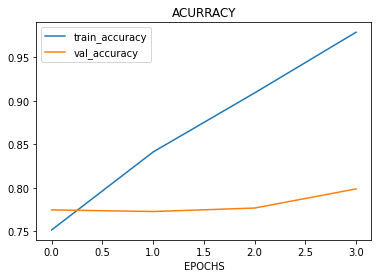

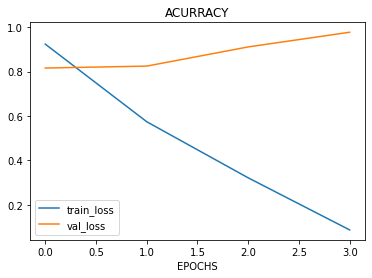

In [ ]:
plot_loss_acc_curve(fine_tune_alldata_101_class_history)

In [ ]:
save_dir_fine_tune ='fine_tune_model_101_class_mix_precision'
load_dir_save_model.save(save_dir_fine_tune)


INFO:tensorflow:Assets written to: fine_tune_model_101_class_mix_precision/assets


INFO:tensorflow:Assets written to: fine_tune_model_101_class_mix_precision/assets


In [ ]:
loaded_load_dir_save_model_fine_tune = tf.keras.models.load_model(save_dir_fine_tune)

In [ ]:
fine_tune_results =loaded_load_dir_save_model_fine_tune.evaluate(test_dataset)

790/790 [==============================] - 62s 76ms/step - loss: 1.0745 - accuracy: 0.7986



## -**Train model with some trainable layers**

In [ ]:
for layer in loaded_load_dir_save_model_fine_tune.layers[1].layers[:10]:
  print(layer.dtype, layer.dtype_policy, layer.trainable, layer.name)

float32 <Policy "float32"> True input_1
float32 <Policy "mixed_float16"> True rescaling
float32 <Policy "float32"> True normalization
float32 <Policy "mixed_float16"> True stem_conv_pad
float32 <Policy "mixed_float16"> True stem_conv
float32 <Policy "mixed_float16"> True stem_bn
float32 <Policy "mixed_float16"> True stem_activation
float32 <Policy "mixed_float16"> True block1a_dwconv
float32 <Policy "mixed_float16"> True block1a_bn
float32 <Policy "mixed_float16"> True block1a_activation


In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in loaded_load_dir_save_model_fine_tune.layers[1].layers[:-10]:
  layer.trainable = False

In [ ]:
for layer in loaded_load_dir_save_model_fine_tune.layers[1].layers:
  print(layer.name, layer.trainable)

In [ ]:
loaded_load_dir_save_model_fine_tune.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            metrics=['accuracy'])

In [ ]:
fine_tune_alldata_101_class_history_100_trainable = loaded_load_dir_save_model_fine_tune.fit(train_dataset, epochs=100, verbose=1,
                                                              validation_data=test_dataset,
                                                              validation_steps=int(0.15*len(test_dataset)),
                                                              steps_per_epoch=len(train_dataset),
                                                                         callbacks=[establish_tensorboard('Fine_Tuning','fine_tune_all_data_101_calss'),
                                                                                    checkpoint_callback_fine_tune, decrease_lr,earlystopping])

save_to:Fine_Tuning/fine_tune_all_data_101_calss/20210818-201716
Epoch 1/100
2368/2368 [==============================] - 368s 150ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 1.3129 - val_accuracy: 0.7868
Epoch 2/100
2368/2368 [==============================] - 356s 149ms/step - loss: 0.0156 - accuracy: 0.9958 - val_loss: 1.3240 - val_accuracy: 0.7895
Epoch 3/100
2368/2368 [==============================] - 355s 148ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 1.3653 - val_accuracy: 0.7871

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
2368/2368 [==============================] - 356s 148ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 1.3740 - val_accuracy: 0.8035


### **-Train with EfficientNetB4**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False)
base_model.trainable = False

inputs = layers.Input(input_shape , name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(101)(x)
outputs = layers.Activation('softmax', dtype = tf.float32, name = 'output_float32')(x)
model_B4 = tf.keras.Model(inputs, outputs)
model_B4.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
for layer in model_B4.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
output_float32 True float32 <Policy "float32">


In [ ]:
for i,layer in enumerate(model_B4.layers[1].layers[:20]):
  print(i,layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
mix_precision_B4_hsitory = model_B4.fit(train_dataset, epochs =5, steps_per_epoch=len(train_dataset), validation_data=test_dataset,
                                  validation_steps=int(0.15 * len(test_dataset)),
                                  callbacks=[establish_tensorboard('mix_percision', 'feature_extraction_full_data'),
                                             model_checkpoint_callback])

save_to:mix_percision/feature_extraction_full_data/20210819-115718
Epoch 1/5
2368/2368 [==============================] - 709s 275ms/step - loss: 2.3198 - accuracy: 0.4561 - val_loss: 1.3239 - val_accuracy: 0.6605
Epoch 2/5
2368/2368 [==============================] - 636s 267ms/step - loss: 1.4250 - accuracy: 0.6304 - val_loss: 1.2443 - val_accuracy: 0.6700
Epoch 3/5
2368/2368 [==============================] - 634s 266ms/step - loss: 1.2611 - accuracy: 0.6692 - val_loss: 1.2068 - val_accuracy: 0.6803
Epoch 4/5
2368/2368 [==============================] - 634s 266ms/step - loss: 1.1597 - accuracy: 0.6959 - val_loss: 1.1976 - val_accuracy: 0.6843
Epoch 5/5
2368/2368 [==============================] - 634s 266ms/step - loss: 1.0795 - accuracy: 0.7137 - val_loss: 1.1857 - val_accuracy: 0.6888



### **- Evaluate model and predicting with it and going through it**

In [ ]:
#Make prediction with our models
pred_prob = loaded_load_dir_save_model_fine_tune.predict(test_dataset, verbose=1)

790/790 [==============================] - 83s 102ms/step


In [ ]:
print(f'how many predictions are done:{len(pred_prob)}')
print(f'shape of pred_prob:{pred_prob.shape}')
print(f'looking at the 10 first prediction:{pred_prob[:10]}')
print(f'The first prediction probability array:{pred_prob[0]},\n lentgh :{len(pred_prob[0])}')
print(f'The highest predicted probability by the model for the first sample:{pred_prob[0].argmax()}')

how many predictions are done:25250
shape of pred_prob:(25250, 101)
looking at the 10 first prediction:[[2.45844421e-05 6.73725242e-16 3.63664611e-12 ... 4.07406664e-10
  7.74286614e-13 5.57191515e-06]
 [5.95499908e-12 4.36333353e-15 2.03768873e-13 ... 1.51428173e-13
  6.84385215e-09 4.64474413e-15]
 [1.06642947e-14 1.01179996e-13 4.17619769e-15 ... 1.35012378e-17
  7.71356937e-13 3.02522740e-16]
 ...
 [1.96676653e-09 5.94806729e-14 5.96058522e-13 ... 1.02342152e-15
  1.12400859e-15 6.61165263e-12]
 [5.20088354e-17 2.48120276e-16 8.39380163e-16 ... 1.60873512e-14
  1.60389924e-08 5.04086942e-17]
 [1.13886117e-03 8.65365852e-12 2.20051679e-13 ... 3.11347336e-04
  7.93630273e-16 9.57574785e-01]]
The first prediction probability array:[2.45844421e-05 6.73725242e-16 3.63664611e-12 1.18242464e-15
 1.47552914e-10 1.35321348e-14 1.06598818e-16 6.58511570e-12
 5.31675823e-06 1.90546624e-11 9.03871200e-10 9.70593283e-17
 2.20241958e-09 1.10114060e-08 3.57487995e-09 9.50104893e-16
 4.53811367e-0

In [ ]:
# Getting the predictions classes for each of samples 
predicted_classes_label = pred_prob.argmax(axis=1)

In [ ]:
len(predicted_classes_label)

25250

In [ ]:
predicted_classes_label[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

# **- In order to evaluate our predicted classes, it requires to compare with the true label of test data.**

In [ ]:
True_labels = []
for image, label in test_dataset.unbatch():
  True_labels.append(label.numpy())

In [ ]:
True_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
from sklearn.metrics import accuracy_score
sk_accuracy = accuracy_score(y_true=True_labels, y_pred=predicted_classes_label, normalize=True)
sk_accuracy

0.7966336633663367

# **Creating confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

#cm = confusion_matrix(True_label, predicted_classes)
def plot_conf_matrix(true_label, pred_label, nclass, figsize=(10,10), norm=False, savefig=False, textsize=10):
  '''
  plotting confusion_matrix with true labels and predicted labels.

  true_label: Array of truth labels (must be same shape as y_pred).
  pred_label: Array of predicted labels (must be same shape as y_true).
  nclass: Array of class labels (e.g. string form). If `None`, integer labels are used.
  norm: if it is true, it normalize the confusion matrix
  figsave: if it is true, it save the plot of confusion_matrix
  '''


  cm = confusion_matrix(true_label, pred_label)

  if norm:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
  else:
    print('without Normalization')
  print(cm)

  #plt.rcParams.update({'font.size': textsize})
  fig, ax = plt.subplots(figsize=figsize)
  tick=np.arange(len(nclass))
  plt.imshow(cm,cmap=plt.cm.Blues)
  plt.colorbar()
  plt.title('confusion_matrix')
  plt.xticks(tick, nclass, rotation=90)
  plt.yticks(tick, nclass)

  thresh = cm.max()/ 2.
  decim = '.2f' if norm else 'd'
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], decim),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  
  plt.xlabel('predicted label')
  plt.ylabel('True_label')
  plt.show

  if savefig:
    fig.savefig("confusion_matrix.png")

without Normalization
[[147   0   7 ...   2   0   9]
 [  0 181   0 ...   0   0   0]
 [ 11   0 214 ...   0   0   0]
 ...
 [  1   0   1 ... 191   0   1]
 [  1   0   0 ...   0 160   1]
 [  4   0   0 ...   0   0 215]]


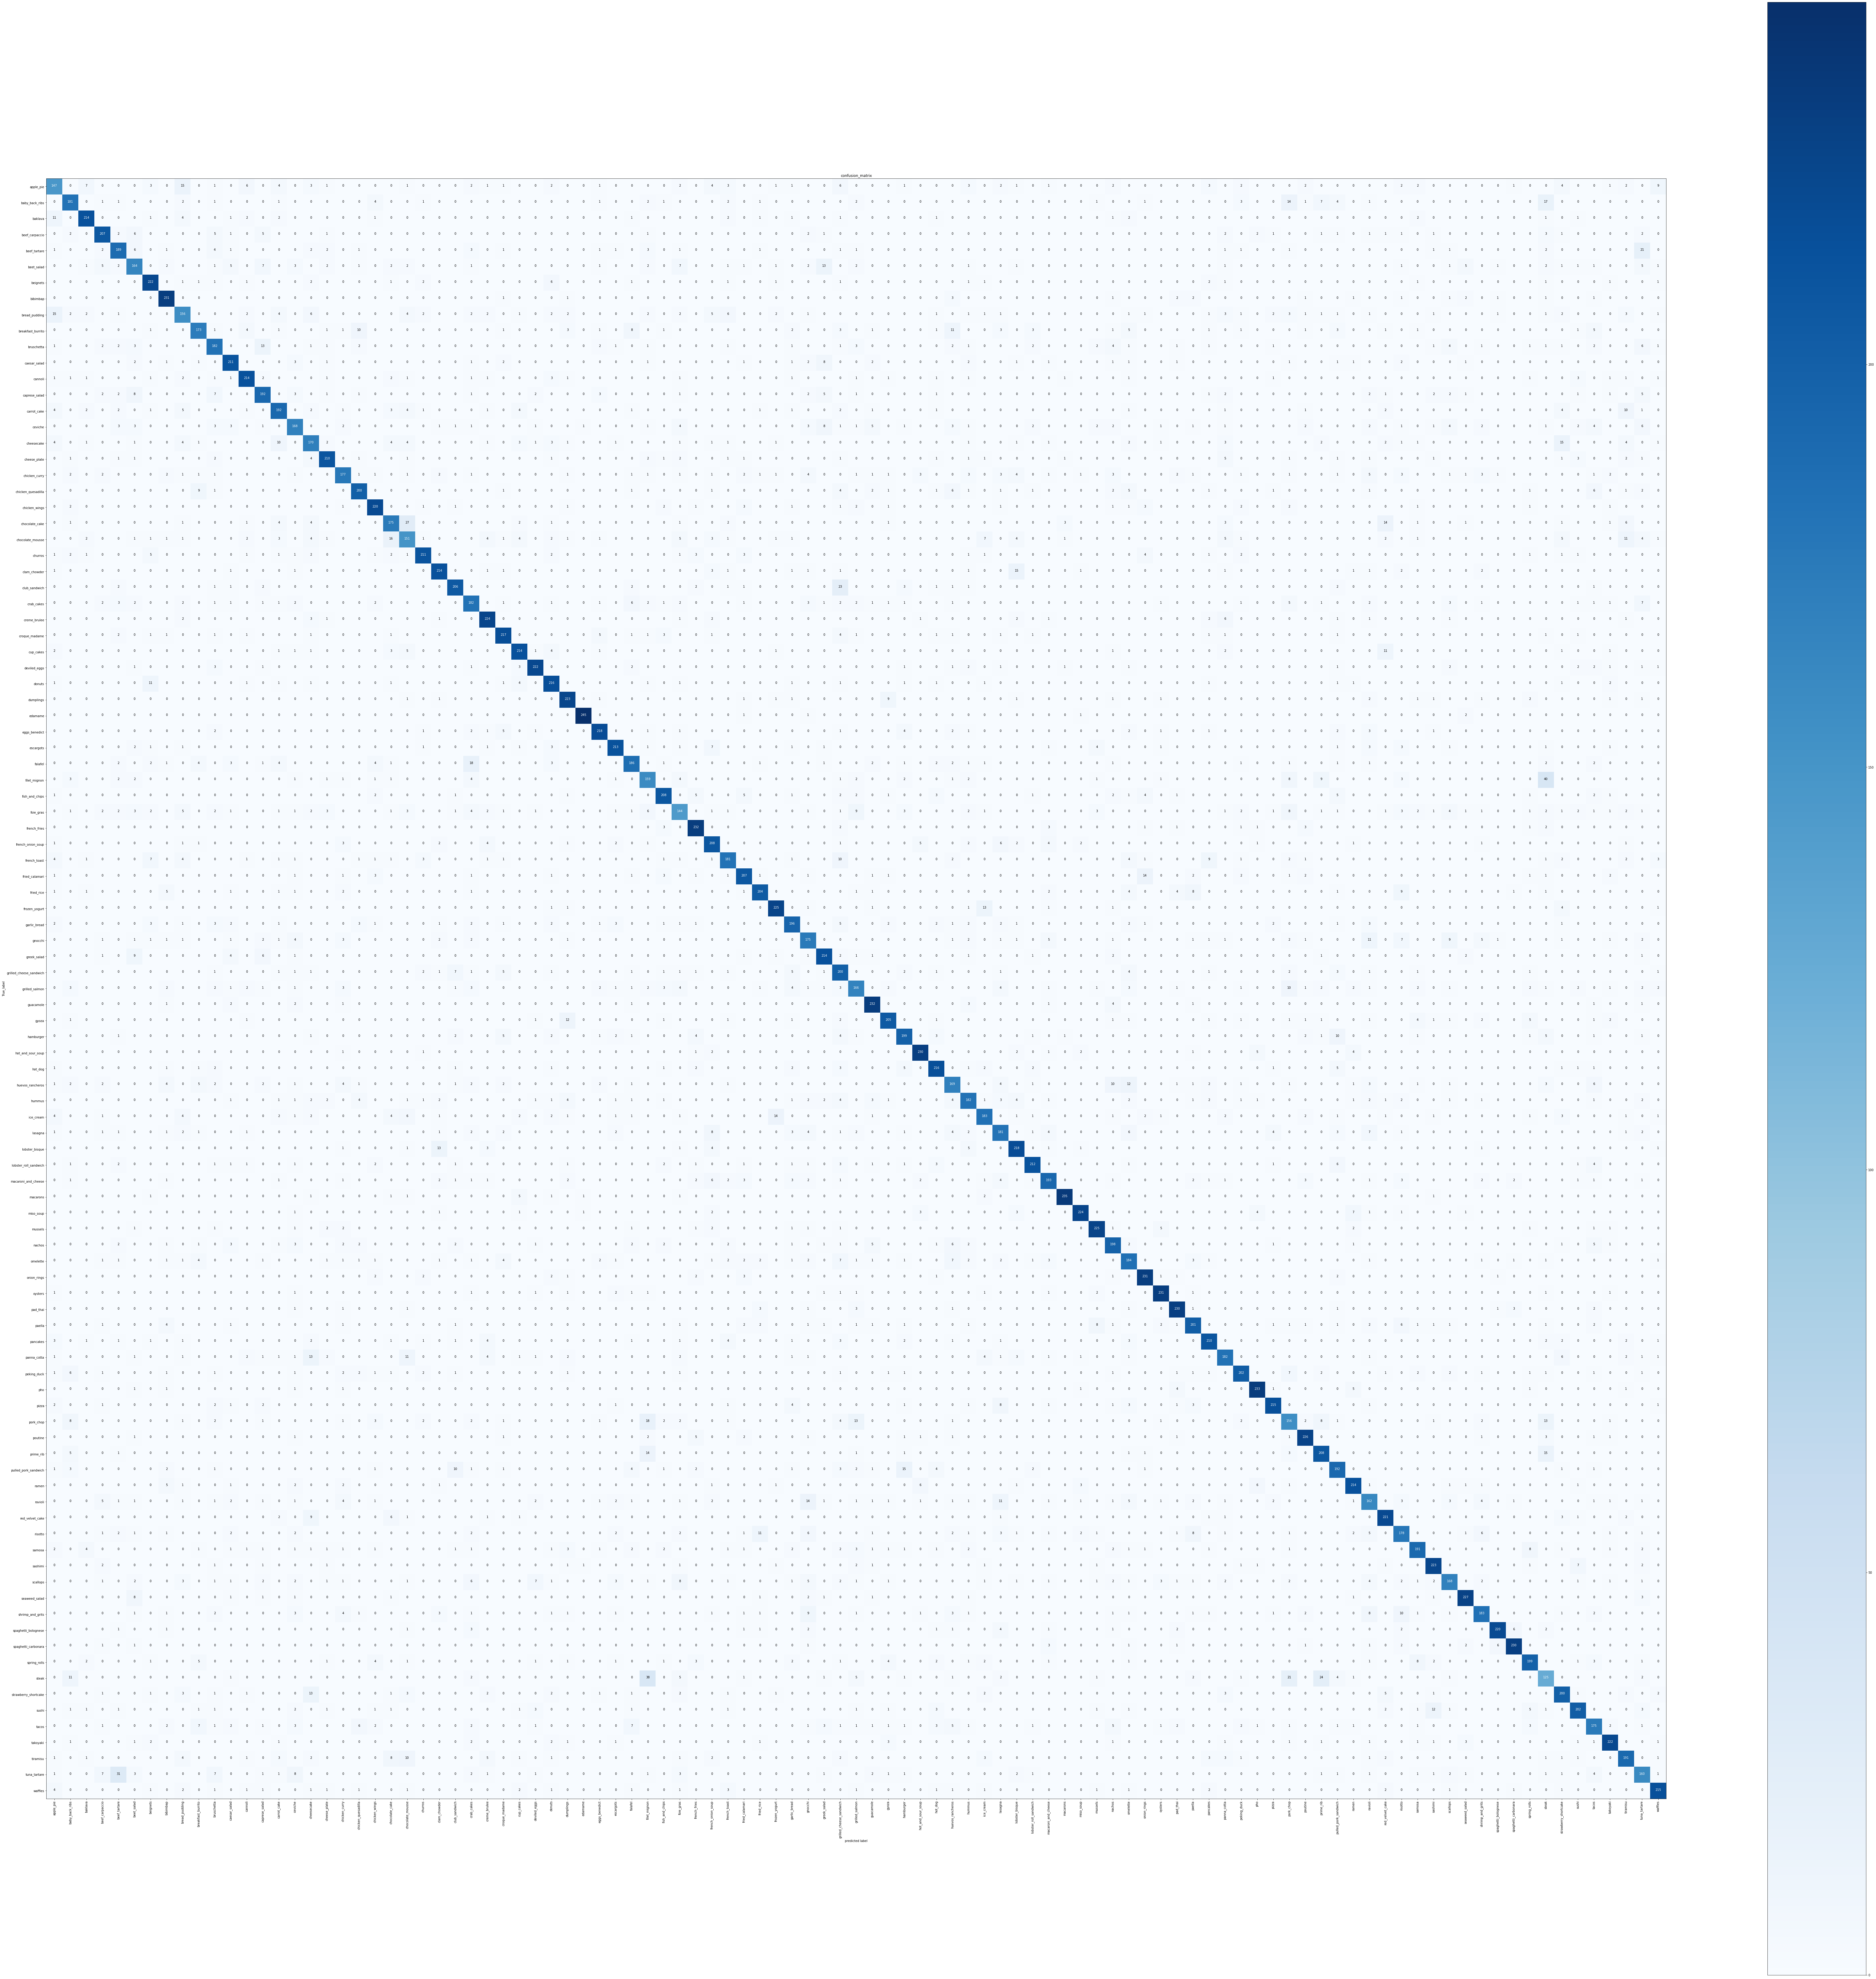

In [ ]:
plot_conf_matrix(True_labels, predicted_classes_label, name_of_classes,figsize=(120,120), savefig=True, textsize=30)

## **Creating horizontal bar chart for comparing f1_score for each class**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(True_labels, predicted_classes_label))

In [ ]:
class_rep_dict = classification_report(True_labels, predicted_classes_label, output_dict= True)


In [ ]:
# creating dictionary for f1_score and class names
f1_rep_class = {}
for key , value in class_rep_dict.items():
  if key=='accuracy':
    break
  f1_rep_class[name_of_classes[int(key)]] = value['f1-score']
f1_rep_class

In [ ]:
import pandas as pd
dic_f1={'class_name':list(f1_rep_class.keys()), 'f1_score':list(f1_rep_class.values())}
f1_rep_df = pd.DataFrame(dic_f1).sort_values(by='f1_score', ascending=False)

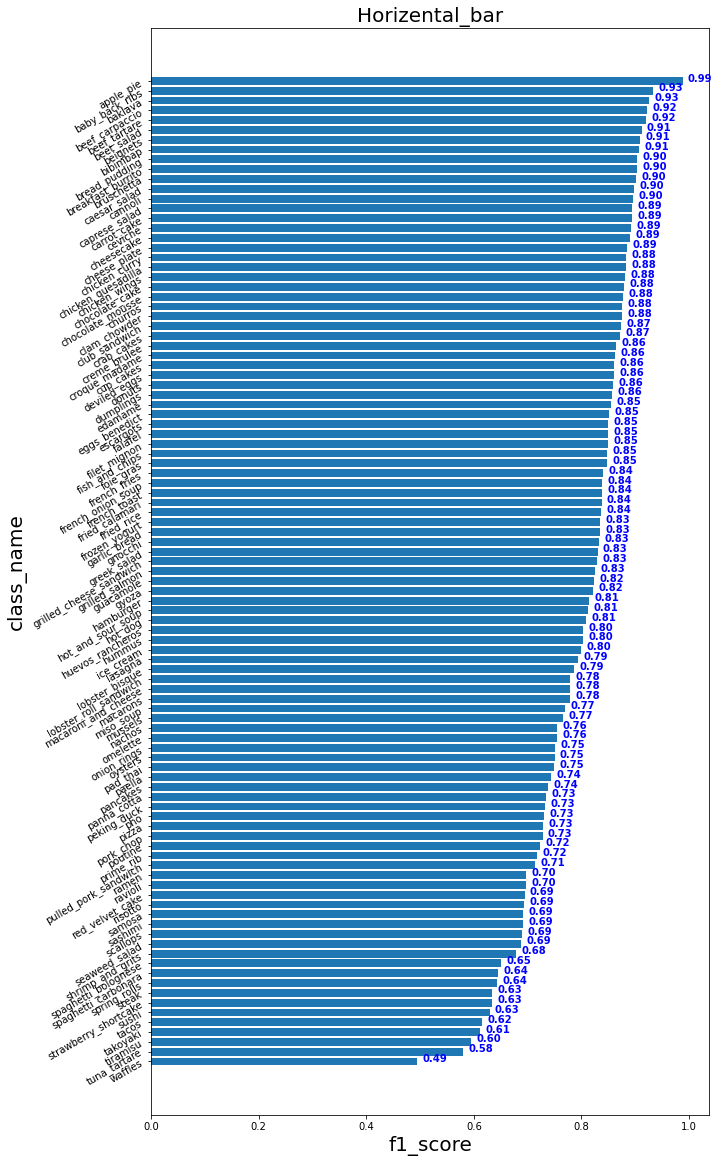

In [ ]:
fig, ax = plt.subplots(figsize=(10,20))
#plt.rcParams.update({'font.size': 10})
xpos = np.arange(len(f1_rep_df['class_name']))
plt.barh(xpos, f1_rep_df['f1_score'])
plt.yticks(range(len(name_of_classes)),name_of_classes,rotation=30, fontsize=10)

for i, v in enumerate(f1_rep_df['f1_score']):
    plt.text(v+0.01, i , format(v,'.2f'), 
            color = 'blue', fontweight = 'bold')
ax.invert_yaxis()   
plt.ylabel('class_name',fontsize=20)
plt.xlabel('f1_score',fontsize=20)
plt.title('Horizental_bar',fontsize=20)
plt.show()

In [ ]:
# Writing a function for prediction on new images
img_size = [224,224]
def preprocess_new_images(filepath, norm=False):
'''
function for getting filepath of new images and meake it ready for giving to model

Args:
filepath(str): path of image
norm: normalize image if necessary
'''
  img = tf.io.read_file(filepath)
  img = tf.io.decode_image(img, channel=3)
  img = tf.image.resize(img, img_size)
  if norm:
    img = img/255.
  else:
    img
  return img